# <center>ECE1724 - Project Implementation</center>
### <center>Team 1 - Multi-criteria optimal routing</center>
**<center>Agasti Kishor Dukare | Student ID: 1005602019</center>**
**<center>Qingqing Zhou | Student ID: 1003782463</center>**
**<center>Yunyi Zhu  | Student ID: 1002079252</center>**

In [1]:
import osmnx as ox
from ipyleaflet import *
import networkx as nx
import plotly.graph_objects as obj
import numpy as np
import poi as p
from common import *
from problem import *
import copy
from tqdm import tqdm
import itertools, heapq, random

## Prepare data
### 1. Load osm data

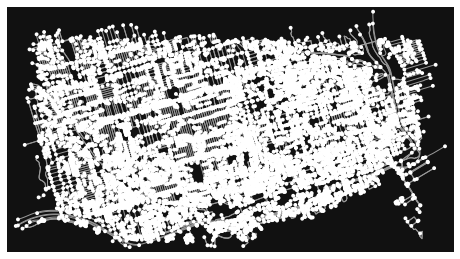

In [2]:
# load the osm data from overpass turbo into osmnx
G1 = ox.graph_from_xml("./data/large_data.osm", retain_all = True)
# plot the graph
fig, ax = ox.plot_graph(G1)

### 2. Add attributes for cost calculation and optimization

  - __travel_time__: calculated by distance/road_speed_limit

In [3]:
# Getting geopandas data frames to have a data structure representing the nodes and the ways in the graph
nodes, edges =  ox.graph_to_gdfs(G1)

list_travel_time = list()
for index, row in edges.iterrows():
    max_speed = 0.0
    if type(row.maxspeed)!=list:
        max_speed = float(row.maxspeed)
    else:
        max_speed = float(min(row.maxspeed))
        
    # typically NaN for highway=service or highway=residential
    # in this case set to 30.0 for now, subject to change
    if max_speed is np.nan:
        max_speed = 30.0
    
    # length is in meter; max_speed is km/h
    # travel time will be represented in seconds for each edge
    list_travel_time.append((row.length * 3600.0)/(max_speed * 1000))

- __num_traffic_signals__: the number of traffic signals belong to this edge/road (a traffic signal will be assgined to its closest road)

In [4]:
nodes_hw = nodes.dropna(subset=['highway'])
nodes_traffic_signals = nodes_hw[nodes_hw.highway=="traffic_signals"]

dict_traffic_signals = dict()
for index, node in nodes_traffic_signals.iterrows():
    nearest_edge = ox.get_nearest_edge(G1, (node.y, node.x))
    if nearest_edge not in dict_traffic_signals:
        dict_traffic_signals[nearest_edge] = 0
    dict_traffic_signals[nearest_edge] += 1

  - __num_bus_stop__: the number of bus stops belong to this edge/road (a bus stop will be assgined to its closest road)

In [5]:
nodes_bus_stop = nodes_hw[nodes_hw.highway=="bus_stop"]
dict_bus_stop = dict()
for index, node in nodes_bus_stop.iterrows():
    nearest_edge = ox.get_nearest_edge(G1, (node.y, node.x))
    if nearest_edge not in dict_bus_stop:
        dict_bus_stop[nearest_edge] = 0
    dict_bus_stop[nearest_edge] += 1

  - __shop__: identify if a specific node is a shop, such as coffee shop or grocery store. Shop will be used as a soft contraint. A route has to be either pass a shop (any shop) or clost to a shop.

In [6]:
# generate random integer values
from random import seed
from random import randint

# can be used to randomly select nodes to be the shops
def pick_random_nodes(nodes, count):
    # generate some integers
    picked_nodes = list()
    for _ in range(10):
        picked_nodes.append(randint(0, len(nodes)))

    return [nodes.iloc[node].osmid for node in picked_nodes]

In [7]:
# add shops to the dataset
shops_osmid = [344474254, 2439311265, 835057395, 2485312016, 49625951, 246693686, 835056613, 577453641, 1721866215, 2725510675]

nodes['shop'] = [True if index in shops_osmid else False for index, _ in nodes.iterrows()]

nodes[nodes['shop']]

,y,x,osmid,highway,ref,geometry,shop
577453641,43.667546,-79.385825,577453641,NaN,NaN,POINT (-79.38583 43.66755),True
49625951,43.665018,-79.387423,49625951,NaN,NaN,POINT (-79.38742 43.66502),True
246693686,43.658334,-79.385672,246693686,NaN,NaN,POINT (-79.38567 43.65833),True
344474254,43.661366,-79.382460,344474254,NaN,NaN,POINT (-79.38246 43.66137),True
835056613,43.657798,-79.401028,835056613,NaN,NaN,POINT (-79.40103 43.65780),True
835057395,43.656436,-79.393640,835057395,NaN,NaN,POINT (-79.39364 43.65644),True
1721866215,43.663212,-79.392351,1721866215,NaN,NaN,POINT (-79.39235 43.66321),True
2439311265,43.668520,-79.399280,2439311265,NaN,NaN,POINT (-79.39928 43.66852),True
2485312016,43.654831,-79.390456,2485312016,NaN,NaN,POINT (-79.39046 43.65483),True
2725510675,43.654587,-79.395290,2725510675,NaN,NaN,POINT (-79.39529 43.65459),True


In [8]:
# form the updated graph 
edges['travel_time'] = list_travel_time
edges['num_traffic_signals'] = [dict_traffic_signals[(row.u, row.v, row.key)] if (row.u, row.v, row.key) in dict_traffic_signals else 0 for index, row in edges.iterrows()]
edges['num_bus_stop'] = [dict_bus_stop[(row.u, row.v, row.key)] if (row.u, row.v, row.key) in dict_bus_stop else 0 for index, row in edges.iterrows()]


G2 = ox.graph_from_gdfs(nodes, edges)

In [9]:
nodes, edges =  ox.graph_to_gdfs(G2)
edges[edges['travel_time'] > 50]

,osmid,bridge,oneway,lanes,highway,maxspeed,length,geometry,travel_time,num_traffic_signals,...,name,width,access,service,tunnel,junction,area,u,v,key
1,"[19882352, 179146498]",yes,True,1,motorway_link,NaN,477.502,"LINESTRING (-79.36064 43.64811, -79.36130 43.6...",57.30024,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3458665,208539722,0
11,"[34398664, 19882354]",yes,True,1,motorway_link,NaN,486.875,"LINESTRING (-79.39935 43.63784, -79.39869 43.6...",58.42500,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3458773,208539758,0
16,"[863872062, 14344984, 4168058, 33805723, 33805...",yes,True,3,motorway,90,2503.475,"LINESTRING (-79.46655 43.63660, -79.46585 43.6...",100.13900,0,...,Gardiner Expressway,NaN,NaN,NaN,NaN,NaN,NaN,3458876,3458858,0
41,"[3996272, 26945412]",NaN,False,2,residential,30,480.499,"LINESTRING (-79.37007 43.67487, -79.37010 43.6...",57.65988,0,...,"[Castle Frank Road, Hawthorn Avenue]",NaN,NaN,NaN,NaN,NaN,NaN,20953419,20953425,0
53,"[3996272, 26945412]",NaN,False,2,residential,30,480.499,"LINESTRING (-79.36882 43.67534, -79.36895 43.6...",57.65988,0,...,"[Castle Frank Road, Hawthorn Avenue]",NaN,NaN,NaN,NaN,NaN,NaN,20953425,20953419,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20546,28637350,NaN,False,NaN,cycleway,20,547.363,"LINESTRING (-79.45897 43.63756, -79.45903 43.6...",98.52534,0,...,Martin Goodman Trail,NaN,NaN,NaN,NaN,NaN,NaN,6491496193,1623028826,0
20846,4017380,NaN,True,1,residential,NaN,458.732,"LINESTRING (-79.34948 43.66958, -79.34647 43.6...",55.04784,0,...,Riverdale Avenue,NaN,NaN,NaN,NaN,NaN,NaN,7132478935,3495869788,0
21074,407269380,NaN,False,NaN,cycleway,NaN,437.371,"LINESTRING (-79.36346 43.67079, -79.36359 43.6...",52.48452,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7490705529,4093188469,0
21393,"[858650160, 858650162]",NaN,True,3,motorway,90,2245.868,"LINESTRING (-79.36243 43.67946, -79.36238 43.6...",89.83472,0,...,Don Valley Parkway,NaN,NaN,NaN,NaN,NaN,NaN,8004320401,2261930321,0


### 3. Select source and destination nodes

In [10]:
# define source and destination
source = 261495554
dest = 8167999285

#### plot the graph with source, destination and shops nodes
 - source and destination are in __red__
 - shops are in __yellow__

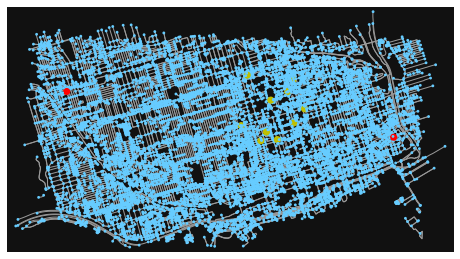

In [11]:
# plot the graph with source, destination and shops
highlighted = [source, dest]

nc = list()
ns = list()
for node in G2.nodes():
    if node in highlighted:
        nc.append('r')
        ns.append(50)
    elif node in shops_osmid:
        nc.append('y')
        ns.append(50)
    else:
        nc.append('#66ccff')
        ns.append(8)

fig, ax = ox.plot_graph(G2, node_size=ns, node_color=nc, node_zorder=2)

## Objective Function 

### 1. Explore objective function on multi-criteria

Two nodes u, v describes an edge:

`G[580005380][1687925400][0]`
```
{'osmid': 45513923,
 'name': 'St. Vincent Lane',
 'highway': 'service',
 'oneway': False,
 'length': 53.025,
 'geometry': <shapely.geometry.linestring.LineString at 0x7fb3b8a163d0>,
 'service': 'alley',
 'travel_time': 1.7674999999999998,
 'num_traffic_signals': 0,
 'num_bus_stop': 0}
 ```

We may calculate cost on each edge by involving __multiple criteria__:

__Criteria 1: Distance of the route__
   - calculated by accumulate length of all the edges that belong to a route
   - optimal solution means minimize the distance of the route
   - use API `cost_dist()` from _common.py_ to account for the cost

In [12]:
# when we only consider the distance of a route
test_route = randomized_search(G2, source, dest)
route_dist = cost_dist(G2, test_route)

print("The cost of a route based on Distance:" + str(route_dist) + " meters")

The cost of a route based on Distance:13110.099000000002 meters


__Criteria 2: Travel time of the route__
   - calculated by accumulate the travel time of all the edges that belong to a route
   - optimal solution means minimize the travel time of the route
   - use API `cost_time()` from _common.py_ to account for the cost


In [13]:
# when we only consider the time of a route
route_time = cost_time(G2, test_route)

print("The cost of a route based on Travel Time:" + str(route_time) + " seconds")

The cost of a route based on Travel Time:1346.0163960000002 seconds


__Optimize on multi-criteria: Distance + Travel time__
   - combine both distance and travel time of all the edges that belong to a route
   - optimal solution means minimize both distance and travel time of the route at the same time

1. Generate 100 routes randomly
1. Calculate the distance cost and time cost respectively for each route
1. Plot them with 2D pareto frontier

In [14]:
def plot_routes(G, routes):
    # generate a set of randomized routes to start with
    RGBA_options = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    route_colors = list()
    num_routes = len(routes)
    
    for i in tqdm(range(num_routes)):
        route_colors.append(RGBA_options[i%len(RGBA_options)])
    
    fig, ax = ox.plot_graph_routes(G, routes, route_colors=route_colors)

100%|██████████| 100/100 [00:00<00:00, 294130.72it/s]


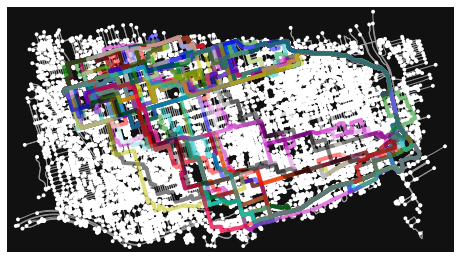

In [15]:
# generate a set of randomized routes to start with
test_routes = list()
num_routes = 100

for i in tqdm(range(num_routes)):
    test_routes.append(randomized_search(G2, source, dest))

plot_routes(G2, test_routes)

In [16]:
import matplotlib.pyplot as plt

def get_pareto_frontier(Xs, Ys, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    
    sorted_list = sorted([[i, Xs[i], Ys[i]] for i in range(len(Xs))], key=lambda cost: cost[1], reverse=maxY)
    pareto_front = [sorted_list[0]]
    
    for pair in sorted_list[1:]:
        if maxY:
            if pair[2] >= pareto_front[-1][2]:
                pareto_front.append(pair)
        else:
            if pair[2] <= pareto_front[-1][2]:
                pareto_front.append(pair)
    
    return pareto_front

def plot_pareto_frontier(Xs, Ys, pareto_front):
    '''Plotting process'''
    plt.scatter(Xs,Ys)
    pf_X = [pair[1] for pair in pareto_front]
    pf_Y = [pair[2] for pair in pareto_front]
    plt.plot(pf_X, pf_Y, 'r')
    plt.xlabel("Distance Cost (m)")
    plt.ylabel("Time Cost (s)")
    plt.show()

- Calculate the distance cost and time cost respectively
- Plot a pareto frontier (in red)

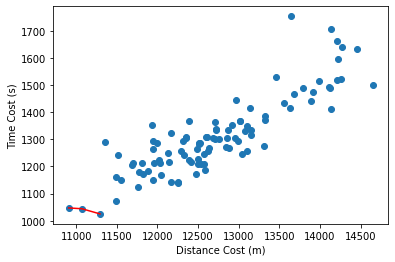

In [17]:
# calculate distance cost and time cost
routes_dist = list()
routes_time = list()

for route in test_routes:
    routes_dist.append(cost_dist(G2, route))
    routes_time.append(cost_time(G2, route))

frontiers = list()
frontiers = get_pareto_frontier(routes_dist, routes_time, maxX=False, maxY=False)
plot_pareto_frontier(routes_dist, routes_time, frontiers)

- Show the frontiers values and plot the frontier routes

In [18]:
# best solutions
frontiers

[[59, 10907.571000000002, 1047.1673219999998],
 [72, 11070.678000000004, 1044.2263439999992],
 [78, 11293.478, 1025.129886]]

100%|██████████| 3/3 [00:00<00:00, 6739.64it/s]


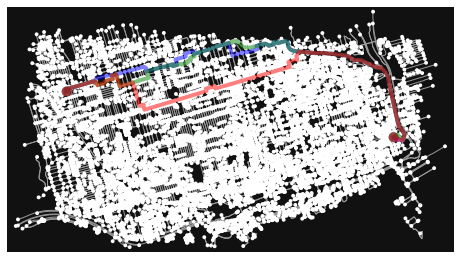

In [19]:
# display best solutions
front_routes = list()

for front in frontiers:
    front_routes.append(test_routes[front[0]])

plot_routes(G2, front_routes)

### 2. Soft constraints

Consider several soft constraints:
  - num_traffic_signals
  - num_bus_stop
  - clost to any shop

Based on the attributes and user preference, we may apply different coefficient and orders to reflect the priority of the soft constraints. Therefore, the overall cost becomes more comprehensive from multiple sources.


__Constraint 1: num_traffic_signals__

This is a static value in a graph, so we pre-calculated `num_traffic_signals` for all the edges


__Constraint 2: num_bus_stop__

This is a static value in a graph, so we pre-calculated `num_bus_stop` for all the edges


__Constraint 3: close to a shop__

This is a dynamic value, so we need to calculate a distance from a route to a shop. Details as below:
  
There are 10 shops in total in the graph. The `shop` attribute is used as one of the soft constraints. Our goal is to find a route that is either passing a shop or close to a shop. Meanwhile, the route should maintain a cost as low as possible.

__Calculate the distance from a shop to a route__
1. loop through all the nodes in a route
2. calculate the haversine distance using `haversine_distance()` for each node
3. use the smallest distance value as the distance between a shop to a route
4. repeat the above steps for all 10 shops
5. take the smallest distance among all the shops as the route to shop distance

In [20]:
def point_to_route_distance(route, point):
    
    dist = np.inf
    
    for node in route:
        tmp_dist = haversine_distance(
            nodes.x[nodes.osmid == point], nodes.y[nodes.osmid == point],
            nodes.x[nodes.osmid == node], nodes.y[nodes.osmid == node])
        
        if tmp_dist < dist:
            dist = tmp_dist

    return dist


def route_shop_dist(route, shops):
    
    dist_shop = np.inf
    best_shop = 0
    
    for shop in shops:
        if shop in route:
            return 0, shop
        else:
            dist = point_to_route_distance(route, shop)
            if dist < dist_shop:
                dist_shop = dist
                best_shop = shop
    
    return dist_shop, best_shop


In [21]:
# calculate shop-route distance for a randomly generated route
dist_shop, best_shop = route_shop_dist(test_route, shops_osmid)

print("Best distance to a shop:" + str(dist_shop))
print("Closest shop for this route:" + str(best_shop))

Best distance to a shop:0.10850739719252918
Closest shop for this route:2439311265


__Plot the the route with the closest shop to it__

- the route is in __purple__
- the best/closest shop to this route is in __yellow__

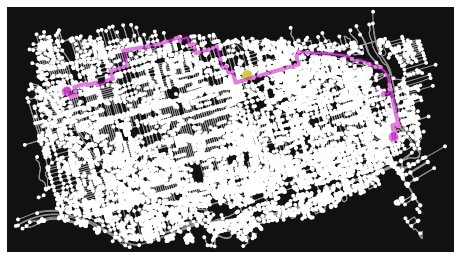

In [22]:
# plot the route
fig, ax = ox.plot_graph_routes(G2, [test_route, [best_shop]], route_colors=['m', 'y'])

__Apply customized cost function__

Use customized API `cost_with_constraints()` from _common.py_ to reflect the cost with multiple constraints

_Note:_ specify different coefficient and the order of power will reflect the different priorities among all the constraints

In [23]:
# distance cost on a route with constraints
route_dist_constraints = cost_with_constraints(G2, test_route, [1, 0.1, 0.5], ['length', 'num_traffic_signals', 'num_bus_stop'],
                                               [1, 1, 1]) + route_shop_dist(test_route, shops_osmid)[0]

# time cost on a route with constraints
route_time_constraints = cost_with_constraints(G2, test_route, [1, 0.1, 0.5], ['travel_time', 'num_traffic_signals', 'num_bus_stop'],
                                               [1, 1, 1]) + route_shop_dist(test_route, shops_osmid)[0]

print("Distance cost on a route with constraints:" + str(route_dist_constraints))
print("Time cost on a route with constraints:" + str(route_time_constraints))

Distance cost on a route with constraints:13115.507507397197
Time cost on a route with constraints:1351.424903397193


## Genetic Algorithm

1. Randomly generately the initial population
1. Run through Genetic Algorithm with below configuration
   - Number of Population: 15 routes
   - Number of Generation: 30
   - Number of Parents: 3

### 1. Generate initial random routes from source to destination

100%|██████████| 45/45 [00:00<00:00, 28259.27it/s]


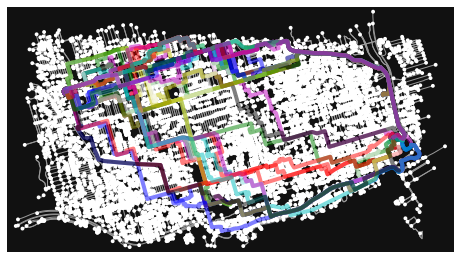

In [24]:
# generate a set of randomized routes to start with
routes = list()
num_population = 45

for i in tqdm(range(num_population)):
    routes.append(randomized_search(G2, source, dest))

plot_routes(G2, routes)

### 2. Run Genetic Algorithm with multiple criteria

In [25]:
# overall cost function
def cost_all(G, cost_func, route, ks, keys, orders, include_shop = False):
    if include_shop:
        return cost_func(G, route, ks, keys, orders) + route_shop_dist(route, shops_osmid)[0]
    else:
        return cost_func(G, route, ks, keys, orders)

# a wrapper function to do GA with user defined cost function
def genetic_algorithm(G, routes_init, cost_func, ks, keys, orders, include_shop = False, num_generations = 30, num_parents = 3):
    
    routes = copy.deepcopy(routes_init)
    
    global_states = list()
    local_states = list()
        
    local_best_routes = list()
    local_best_cost = np.inf
    
    global_best_route = list()
    global_best_cost = local_best_cost

    local_states.append(local_best_cost)
    global_states.append(global_best_cost)
        
    for generation in tqdm(range(num_generations)):
        # user defined cost function
        costs = [cost_all(G, cost_func, route, ks, keys, orders, include_shop) for route in routes]
        
        # convert cost to probability distance for select_best
        prob_dist = [1/x for x in costs]
        
        # this is a roulette wheel selection from problem.py
        # TODO: could try different selection algorithms later
        parents_1 = select_best(routes, num_parents, prob_dist)
        
        # naive cross_over() from problem.py that only recombines when there are intersections
        # TODO: replace it with better cross_over algorithms
        parents_2 = [cross_over(route_1, route_2) for route_1, route_2 in itertools.product(parents_1, repeat = 2)]
        parents_2 = heapq.nsmallest(num_parents, parents_2, key = lambda route : 
                                    cost_all(G, cost_func, route, ks, keys, orders, include_shop))
        
        # TODO: could replace mutate() with other mutation implementation
        parents = [mutate(G, route) for route in parents_2]
        
        # a local search on the neighbours using the children_route() implementation from common.py
        # generate the offspring of these parents -- each parent will generate 15/3=5 children
        # for 3 parents in total, we will generate a set of 15 routes which maintains the same pool size
        routes = flatten([[*itertools.islice(children_route(G, route), num_population // num_parents)] for route in parents])
        
        # remove duplicates
        routes = [*map(list, list(set(map(tuple, routes))))]
        
        # see how many routes have been removed and fill the routes with random ones til the number num_population
        num_removed = num_population - len(routes) + 1
        routes.extend([randomized_search(G, source, dest) for _ in range(num_removed)])
        
        # to track the best route at each iteration
        local_best_route = min(routes, key = lambda route : 
                               cost_all(G, cost_func, route, ks, keys, orders, include_shop))
        local_best_cost = cost_all(G, cost_func, local_best_route, ks, keys, orders, include_shop)
        if local_best_cost < global_best_cost:
            global_best_route = copy.deepcopy(local_best_route)
            global_best_cost = local_best_cost
        
        local_best_routes.append(local_best_route)
        local_states.append(local_best_cost)
        global_states.append(global_best_cost)
        
    return local_best_routes, global_best_route, local_states, global_states

In [26]:
import matplotlib.pyplot as plt

def plot_iteration_states(local_states, global_states, criteria_text):
    plt.xlabel("number of generation")
    plt.ylabel(criteria_text)
    plt.plot(local_states, label = "local_best")
    plt.plot(global_states, label = "global_best")
    plt.legend()
    plt.show()

#### Case 1: Use criteria `Distance of a route`

$cost = \sum_{edges}{edge[length]} + constraints$

In [27]:
# use distance cost
GA_local_best_routes_dist, GA_global_best_route_dist, GA_local_states_dist, GA_global_states_dist = genetic_algorithm(
    G2, routes, cost_with_constraints, [1, 0.1, 0.5], ['length', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True)

100%|██████████| 30/30 [17:58:02<00:00, 2156.07s/it]   


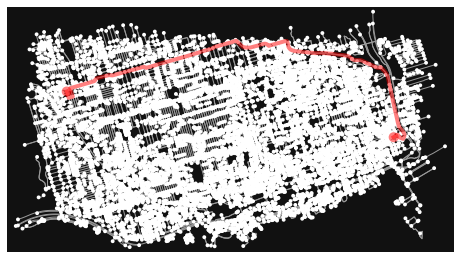

In [28]:
fig, ax = ox.plot_graph_route(G2, GA_global_best_route_dist)

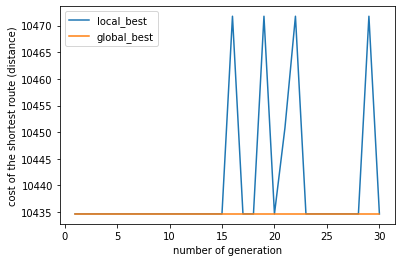

In [29]:
# the progress of the cost from both local and global best
plot_iteration_states(GA_local_states_dist, GA_global_states_dist, 'cost of the shortest route (distance)')

#### Case 2. Use criteria `Travel Time of a route`

$cost = \sum_{edges}{edge[travel\_time]} + constraints$

In [30]:
# use time cost
GA_local_best_routes_time, GA_global_best_route_time, GA_local_states_time, GA_global_states_time = genetic_algorithm(
    G2, routes, cost_with_constraints, [1, 0.1, 0.5], ['travel_time', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True)

100%|██████████| 30/30 [17:16:27<00:00, 2072.93s/it]  


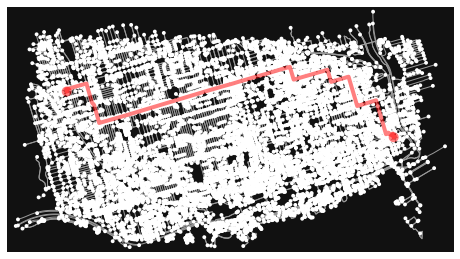

In [31]:
fig, ax = ox.plot_graph_route(G2, GA_global_best_route_time)

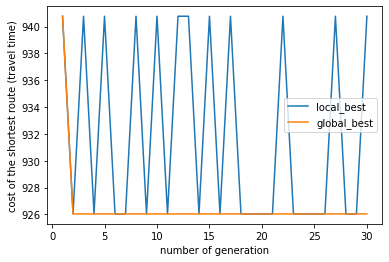

In [32]:
# the progress of the cost from both local and global best
plot_iteration_states(GA_local_states_time, GA_global_states_time, 'cost of the shortest route (travel time)')

#### Case 3: combine both `Distance` and `Travel Time`

collect all the local best on each iteration and plot pareto frontier

In [33]:
# calculate distance cost and time cost
def process_pareto(G, routes, include_shop=True):
    
    ks = [1, 0.1, 0.5]
    keys_dist = ['length', 'num_traffic_signals', 'num_bus_stop']
    keys_time = ['travel_time', 'num_traffic_signals', 'num_bus_stop']
    orders=[1, 1, 1]
    
    routes_dist = list()
    routes_time = list()
    
    for route in routes:
        routes_dist.append(cost_all(G, cost_with_constraints, route, ks, keys_dist, orders, include_shop))
        routes_time.append(cost_all(G, cost_with_constraints, route, ks, keys_time, orders, include_shop))
    
    frontiers = list()
    frontiers = get_pareto_frontier(routes_dist, routes_time, maxX=False, maxY=False)
    
    return routes_dist, routes_time, frontiers

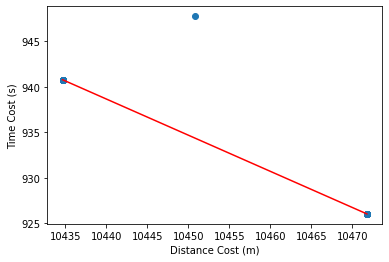

In [34]:
# get frontier
GA_route_candidates = GA_local_best_routes_dist + GA_local_best_routes_time
GA_routes_dist, GA_routes_time, GA_frontiers = process_pareto(G2, GA_route_candidates)

# plot frontier
plot_pareto_frontier(GA_routes_dist, GA_routes_time, GA_frontiers)

100%|██████████| 59/59 [00:00<00:00, 186765.23it/s]


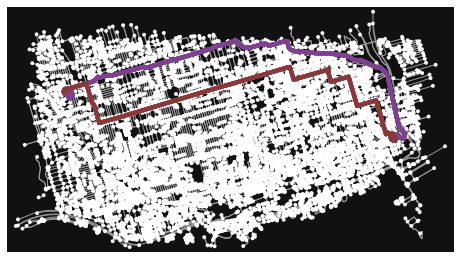

In [35]:
# display best solutions
GA_frontier_routes = list()

for front in GA_frontiers:
    GA_frontier_routes.append(GA_route_candidates[front[0]])

plot_routes(G2, GA_frontier_routes)

## Particle Swarm Optimization (PSO)

1. We will use the same dataset and source/destination nodes as for Genetic Algorithm
   - refer to `3. Select source and destination nodes`
1. Randomly generately the initial population
1. Run through __PSO__ with below configuration
   - Number of Particles in all swarms: 200 routes
   - Number of swarms: 4
   - Number of iterations: 50

### 1. Generate initial particles/routes

In [36]:
# prepare the souce and destination nodes
origin_node = Node(graph = G2, osmid = source)
dest_node = Node(graph = G2, osmid = dest)

# configure PSO model
particles_swarm = 200
num_of_swarms = 4
num_of_iterations = 50

100%|██████████| 200/200 [00:00<00:00, 560361.26it/s]


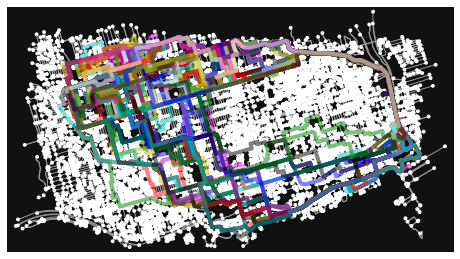

In [37]:
# generate initial particles randomly
routes.clear()

for i in tqdm(range(particles_swarm)):
    routes.append(randomized_search(G2, source, dest))

plot_routes(G2, routes)

### 2. Run PSO with multi-crieria

In [38]:
def pso(G, particles_init, cost_func, ks, keys, orders, include_shop, particles_swarm = 200, num_of_swarms = 4, 
        num_of_iterations = 50):
    
    particles = copy.deepcopy(particles_init)
    
    global_states = list()
    local_states = list()
        
    local_best_routes = list()
    local_best_cost = np.inf
    
    global_best_route = list()
    global_best_cost = local_best_cost

    local_states.append(local_best_cost)
    global_states.append(global_best_cost)
    
    for iteration in tqdm(range(num_of_iterations)):
        
        # we need to have `num_of_swarms` particles to lead
        # a swarm and be its lbest ... that changes every iteration
        particles.sort(key = lambda particle : 
                       cost_all(G, cost_func, particle, ks, keys, orders, include_shop))
        swarm_particles = particles_swarm // num_of_swarms
        
        leaders = particles[:swarm_particles][:]
        
        for i in range(num_of_swarms):
            particles[i] , particles[i * swarm_particles] = particles[i * swarm_particles], particles[i]
        
        swarms = list()
        
        for i in range(num_of_swarms):
            swarms.append(particles[i * (swarm_particles): i*(swarm_particles) + swarm_particles])
        
        # for each swarm follow the leader of the swarm
        def follow_leader_local(population):
            for i in range(1, len(population)):
                population[i] = cross_over(population[0], population[i]) # this is what we are doing
        
        for swarm in swarms:
            follow_leader_local(swarm)
        
        def follow_leader_global():
            for u, v in itertools.product(range(0, len(leaders)), range(0, len(leaders))):
                tobeMutated = random.choice([u, v])
                leaders[tobeMutated] = cross_over(leaders[u], leaders[v])
        
        follow_leader_global()
        
        # adding the new leaders
        for i in range(num_of_swarms):
            particles[i * swarm_particles] = leaders[i]

        # to track the best route at each iteration    
        local_best_route = min(particles, key = lambda particle : 
                               cost_all(G, cost_func, particle, ks, keys, orders, include_shop))
        local_best_cost = cost_all(G, cost_func, local_best_route, ks, keys, orders, include_shop)
        
        if local_best_cost < global_best_cost:
            global_best_route = copy.deepcopy(local_best_route)
            global_best_cost = local_best_cost
        
        local_states.append(local_best_cost)
        local_best_routes.append(local_best_route)
        global_states.append(global_best_cost)
    
    return local_best_routes, global_best_route, local_states, global_states

#### Case 1: Use criteria `Distance of a route`

$cost = \sum_{edges}{edge[length]} + constraints$

In [39]:
# use distance cost
PSO_local_best_routes_dist, PSO_global_best_route_dist, PSO_local_states_dist, PSO_global_states_dist = pso(
    G2, routes, cost_with_constraints, [1, 0.1, 0.5], ['length', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True)

100%|██████████| 50/50 [6:21:55<00:00, 458.32s/it]  


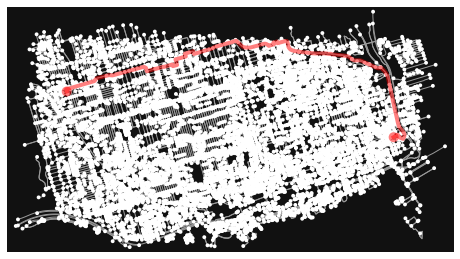

In [40]:
fig, ax = ox.plot_graph_route(G2, PSO_global_best_route_dist)

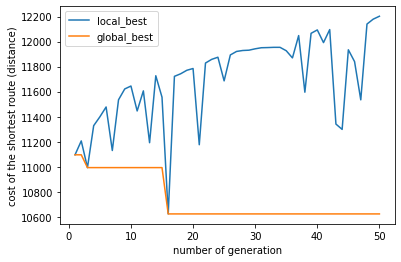

In [41]:
# the progress of the cost from both local and global best
plot_iteration_states(PSO_local_states_dist, PSO_global_states_dist, 'cost of the shortest route (distance)')

#### Case 2. Use criteria `Travel Time of a route`

$cost = \sum_{edges}{edge[travel\_time]} + constraints$

In [42]:
# use time cost
PSO_local_best_routes_time, PSO_global_best_route_time, PSO_local_states_time, PSO_global_states_time = pso(
    G2, routes, cost_with_constraints, [1, 0.1, 0.5], ['travel_time', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True)

100%|██████████| 50/50 [7:59:24<00:00, 575.28s/it]  


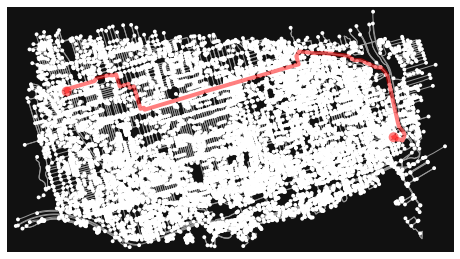

In [43]:
fig, ax = ox.plot_graph_route(G2, PSO_global_best_route_time)

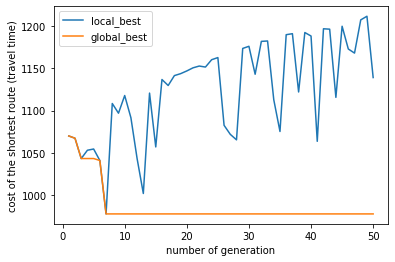

In [44]:
# the progress of the cost from both local and global best
plot_iteration_states(PSO_local_states_time, PSO_global_states_time, 'cost of the shortest route (travel time)')

#### Case 3: combine both `Distance` and `Travel Time`

collect all the local best on each iteration and plot pareto frontier

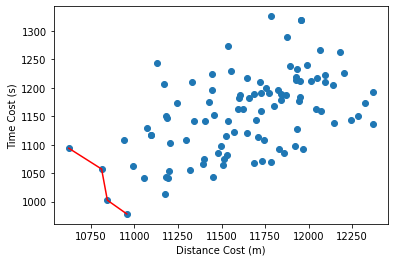

In [45]:
# get frontier
PSO_route_candidates = PSO_local_best_routes_dist + PSO_local_best_routes_time
PSO_routes_dist, PSO_routes_time, PSO_frontiers = process_pareto(G2, PSO_route_candidates)

# plot frontier
plot_pareto_frontier(PSO_routes_dist, PSO_routes_time, PSO_frontiers)

100%|██████████| 4/4 [00:00<00:00, 2318.26it/s]


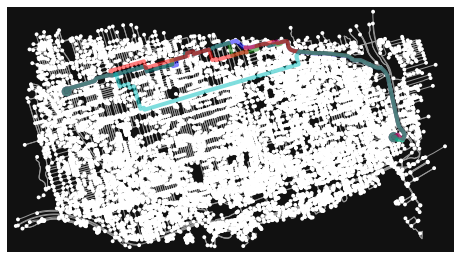

In [46]:
# display best solutions
PSO_frontier_routes = list()

for front in PSO_frontiers:
    PSO_frontier_routes.append(PSO_route_candidates[front[0]])

plot_routes(G2, PSO_frontier_routes)

## Compare GA and PSO

### 1. Get unique routes from frontiers

In [47]:
def is_in_list(target_list, source):
    for item in target_list:
        if item[1] == source[1] and item[2] == source[2]:
            return True
    return False

In [48]:
GA_unique = list()

for item in GA_frontiers:
    if not is_in_list(GA_unique, item):
        GA_unique.append(item)

len(GA_unique)

2

In [49]:
PSO_unique = list()

for item in PSO_frontiers:
    if not is_in_list(PSO_unique, item):
        PSO_unique.append(item)

len(PSO_unique)

4

### 2. Normalize the best solution from both GA and PSO (Min-Max)

In [50]:
import pandas as pd 

costs_dist = list()
costs_time = list()
algos = list()

for item in GA_unique:
    costs_dist.append(item[1])
    costs_time.append(item[2])
    algos.append('GA')

for item in PSO_unique:
    costs_dist.append(item[1])
    costs_time.append(item[2])
    algos.append('PSO')

df = pd.DataFrame(zip(algos, costs_dist, costs_time),columns=['Bio-Algo','Cost-Dist','Cost-Time'])

In [51]:
# use min-max normalization
norm_df = df
norm_df['Cost-Dist'] = (norm_df['Cost-Dist']-norm_df['Cost-Dist'].min()+1)/(norm_df['Cost-Dist'].max()-norm_df['Cost-Dist'].min()+1)
norm_df['Cost-Time'] = (norm_df['Cost-Time']-norm_df['Cost-Time'].min()+1)/(norm_df['Cost-Time'].max()-norm_df['Cost-Time'].min()+1)

# apply overall cost by Cost-Dist + Cost-Time
norm_df['Cost-All'] = norm_df['Cost-Dist'] + norm_df['Cost-Time']
norm_df

,Bio-Algo,Cost-Dist,Cost-Time,Cost-All
0,GA,0.001914,0.093293,0.095207
1,GA,0.072946,0.005927,0.078873
2,PSO,0.362970,1.000000,1.362970
3,PSO,0.723349,0.783342,1.506691
4,PSO,0.786806,0.458275,1.245081
5,PSO,1.000000,0.315597,1.315597


### 3. Plot best solutions from both GA and PSO

- GA in blue
- PSO in orange

In [52]:
def plot_best(df, key, title):
    # sort by key
    sorted_df = df.sort_values(by=[key])
    
    colors =['C0' if sorted_df['Bio-Algo'][ind]=='GA' else 'C1' for ind in sorted_df.index]
    ax = sorted_df[key].plot.bar(color=colors, legend=False, title=title)

In [53]:
norm_df.sort_values(by=['Cost-Dist'])

,Bio-Algo,Cost-Dist,Cost-Time,Cost-All
0,GA,0.001914,0.093293,0.095207
1,GA,0.072946,0.005927,0.078873
2,PSO,0.362970,1.000000,1.362970
3,PSO,0.723349,0.783342,1.506691
4,PSO,0.786806,0.458275,1.245081
5,PSO,1.000000,0.315597,1.315597


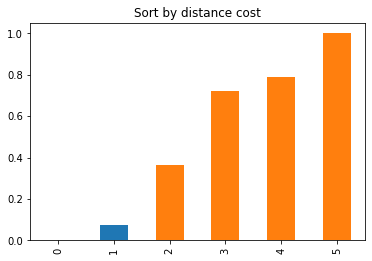

In [54]:
# sort by distance
plot_best(norm_df, 'Cost-Dist', "Sort by distance cost")

In [55]:
norm_df.sort_values(by=['Cost-Time'])

,Bio-Algo,Cost-Dist,Cost-Time,Cost-All
1,GA,0.072946,0.005927,0.078873
0,GA,0.001914,0.093293,0.095207
5,PSO,1.000000,0.315597,1.315597
4,PSO,0.786806,0.458275,1.245081
3,PSO,0.723349,0.783342,1.506691
2,PSO,0.362970,1.000000,1.362970


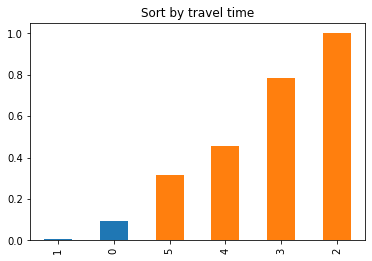

In [56]:
# sort by travel time
plot_best(norm_df, 'Cost-Time', "Sort by travel time")

In [57]:
norm_df.sort_values(by=['Cost-All'])

,Bio-Algo,Cost-Dist,Cost-Time,Cost-All
1,GA,0.072946,0.005927,0.078873
0,GA,0.001914,0.093293,0.095207
4,PSO,0.786806,0.458275,1.245081
5,PSO,1.000000,0.315597,1.315597
2,PSO,0.362970,1.000000,1.362970
3,PSO,0.723349,0.783342,1.506691


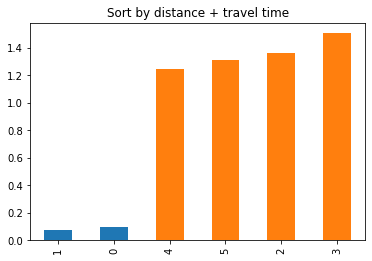

In [58]:
# sort by overall cost
plot_best(norm_df, 'Cost-All', "Sort by distance + travel time")